In [1]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import yaml
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from PIL import Image

In [2]:
# INPUT_DIRS
INPUT_DATA_DIR = Path('dataset')

os.listdir(INPUT_DATA_DIR)

['predictions',
 'SampleSubmission.csv',
 'dataset.zip',
 'Test.csv',
 'Train.csv',
 'Cocoa_Disease_Starter_Notebook.ipynb',
 'Train_df.csv',
 'images',
 'Val_df.csv',
 'labels',
 'evaluations']

In [3]:
## Drop the Folder if it already exists
DATASETS_DIR = Path('dataset')
DATASETS_DIR

PosixPath('dataset')

In [4]:
# Image & labels directory
TRAIN_IMAGES_DIR = DATASETS_DIR / 'images' / 'train'
TRAIN_LABELS_DIR = DATASETS_DIR / 'labels'/ 'train'
TEST_IMAGES_DIR = DATASETS_DIR / 'images' / 'test'
VAL_IMAGES_DIR = DATASETS_DIR / 'images' /'val'
VAL_LABELS_DIR = DATASETS_DIR / 'labels' /'val'

In [5]:
# Check if DATASETS_DIR exists, if it does delete it and recreate it
for DIR in [
    TRAIN_IMAGES_DIR,
    VAL_IMAGES_DIR,
    TEST_IMAGES_DIR,
    VAL_LABELS_DIR,
    # DATASETS_DIR,
]:
    if DIR.exists():
        shutil.rmtree(DIR)
    DIR.mkdir(parents=True, exist_ok=True)
DATASETS_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
shutil.unpack_archive(INPUT_DATA_DIR / 'dataset.zip', DATASETS_DIR)

In [7]:
def count_files(directory):
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

In [8]:
## Count the number files in TRAIN_IMAGES_DIR
num_train_images = count_files(TRAIN_IMAGES_DIR)
print(f"There are {num_train_images} in {TRAIN_IMAGES_DIR}")

There are 5529 in dataset/images/train


In [9]:
## Count the number of files in TRAIN_LABELS_DIR
num_test_labels = count_files(TEST_IMAGES_DIR)
print(f"There are {num_test_labels} in {TEST_IMAGES_DIR}")

There are 1626 in dataset/images/test


In [10]:
## Get the set of all the stems of the images in TRAIN_IMAGES_DIR
train_images_stems = set([str(Path(name).stem) for name in os.listdir(TRAIN_IMAGES_DIR)])
len(train_images_stems)

5529

In [11]:
## Get the set of all the stems of the labes in TRAIN_LABELS_DIR
train_labels_stems = set([str(Path(name).stem) for name in os.listdir(TRAIN_LABELS_DIR)])
len(train_labels_stems)

5529

In [12]:
# Check that the two sets are identitical
train_images_stems == train_labels_stems

True

In [13]:
TRAIN_IMAGES_DIR.absolute()

PosixPath('/data/home/eak/learning/nganga_ai/AminiCocoa/Amini-Cocoa-Contamination-Challenge/dataset/images/train')

In [14]:
# Load train and test files
train = pd.read_csv(INPUT_DATA_DIR / 'Train.csv')
test = pd.read_csv(INPUT_DATA_DIR / 'Test.csv')
ss = pd.read_csv(INPUT_DATA_DIR / 'SampleSubmission.csv')

In [15]:
## Sample submission file
ss.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_Genxyu.jpg,healthy,0.5,100,100,100,100
1,ID_svY6TG.jpg,healthy,0.5,100,100,100,100
2,ID_d0gpda.jpg,healthy,0.5,100,100,100,100
3,ID_frWmBT.jpg,healthy,0.5,100,100,100,100
4,ID_TaRW6o.jpg,healthy,0.5,100,100,100,100


In [16]:
train.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath
0,ID_nBgcAR.jpg,healthy,1.0,75.0,15.0,162.0,195.0,2,dataset/images/train/ID_nBgcAR.jpg
1,ID_nBgcAR.jpg,healthy,1.0,58.0,1.0,133.0,171.0,2,dataset/images/train/ID_nBgcAR.jpg
2,ID_nBgcAR.jpg,healthy,1.0,42.0,29.0,377.0,349.0,2,dataset/images/train/ID_nBgcAR.jpg
3,ID_Kw2v8A.jpg,healthy,1.0,112.0,124.0,404.0,341.0,2,dataset/images/train/ID_Kw2v8A.jpg
4,ID_Kw2v8A.jpg,healthy,1.0,148.0,259.0,413.0,412.0,2,dataset/images/train/ID_Kw2v8A.jpg


In [17]:
train['class'].unique()

array(['healthy', 'anthracnose', 'cssvd'], dtype=object)

In [18]:
train['class_id'].unique()

array([2, 0, 1])

In [19]:
train[['class', 'class_id']].value_counts()

class        class_id
healthy      2           4279
cssvd        1           3223
anthracnose  0           2271
cssvd        0             18
healthy      1              1
Name: count, dtype: int64

In [20]:
class_map = {cls: i for i, cls in enumerate(sorted(train['class'].unique().tolist()))}
class_map

{'anthracnose': 0, 'cssvd': 1, 'healthy': 2}

In [21]:
# Strip any spacing from the class item and make sure that it is a str
train['class'] = train['class'].str.strip()

# Map {'healthy': 2, 'cssvd': 1, anthracnose: 0}
train['class_id'] = train['class'].map(class_map)

In [22]:
train[['class', 'class_id']].value_counts()

class        class_id
healthy      2           4280
cssvd        1           3241
anthracnose  0           2271
Name: count, dtype: int64

In [23]:
# Number of unique images path
train['ImagePath'].nunique()

5529

In [24]:
unique_train = train.drop_duplicates(subset=["Image_ID"])
len(unique_train)

5529

In [25]:
# Split the train dataset into train_df & val_df
train_names, val_names = train_test_split(
    unique_train["Image_ID"].values,
    stratify=unique_train["class_id"],
    test_size=0.2,
    random_state=42,
)

train_df = train[train["Image_ID"].isin(train_names)]
val_df = train[train["Image_ID"].isin(val_names)]

In [26]:
train_df.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath
0,ID_nBgcAR.jpg,healthy,1.0,75.0,15.0,162.0,195.0,2,dataset/images/train/ID_nBgcAR.jpg
1,ID_nBgcAR.jpg,healthy,1.0,58.0,1.0,133.0,171.0,2,dataset/images/train/ID_nBgcAR.jpg
2,ID_nBgcAR.jpg,healthy,1.0,42.0,29.0,377.0,349.0,2,dataset/images/train/ID_nBgcAR.jpg
3,ID_Kw2v8A.jpg,healthy,1.0,112.0,124.0,404.0,341.0,2,dataset/images/train/ID_Kw2v8A.jpg
4,ID_Kw2v8A.jpg,healthy,1.0,148.0,259.0,413.0,412.0,2,dataset/images/train/ID_Kw2v8A.jpg


In [27]:
train_df.shape, val_df.shape, test.shape

((7830, 9), (1962, 9), (1626, 9))

In [28]:
ss.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_Genxyu.jpg,healthy,0.5,100,100,100,100
1,ID_svY6TG.jpg,healthy,0.5,100,100,100,100
2,ID_d0gpda.jpg,healthy,0.5,100,100,100,100
3,ID_frWmBT.jpg,healthy,0.5,100,100,100,100
4,ID_TaRW6o.jpg,healthy,0.5,100,100,100,100


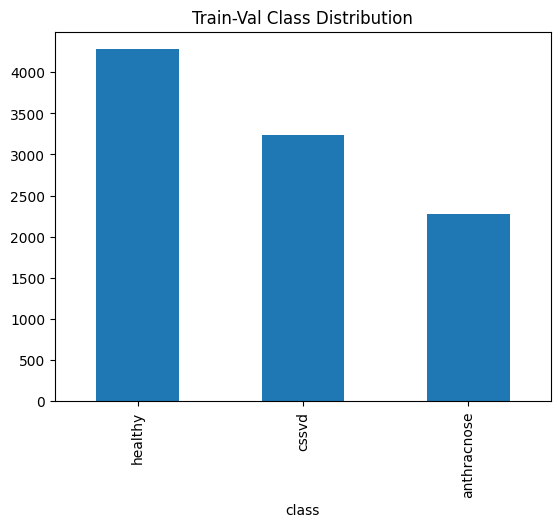

In [29]:
# Preview target distribution, seems there a class imbalance that needs to be handled
train['class'].value_counts().plot(kind='bar')
plt.title('Train-Val Class Distribution')
plt.show()

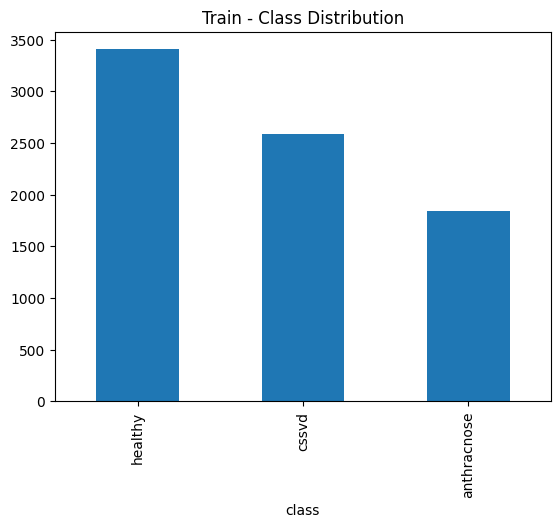

In [30]:
train_df['class'].value_counts().plot(kind='bar')
plt.title('Train - Class Distribution')
plt.show()

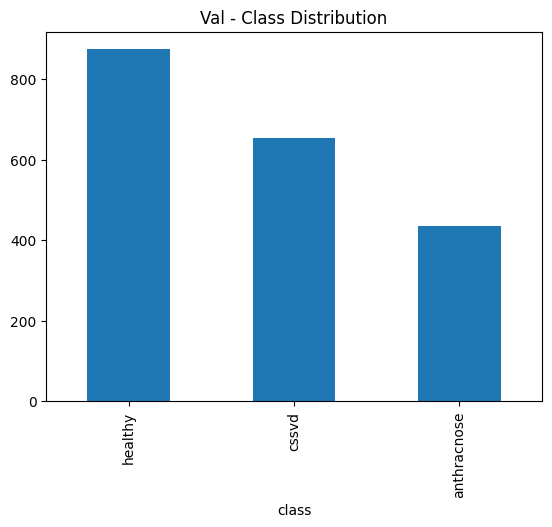

In [31]:
val_df['class'].value_counts().plot(kind='bar')
plt.title('Val - Class Distribution')
plt.show()

In [32]:
# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    "path" : str(DATASETS_DIR.absolute()),
    'train': str(TRAIN_IMAGES_DIR.absolute()),
    'val': str(VAL_IMAGES_DIR.absolute()),
    'test': str(TEST_IMAGES_DIR.absolute()),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'path': '/data/home/eak/learning/nganga_ai/AminiCocoa/Amini-Cocoa-Contamination-Challenge/dataset',
 'train': '/data/home/eak/learning/nganga_ai/AminiCocoa/Amini-Cocoa-Contamination-Challenge/dataset/images/train',
 'val': '/data/home/eak/learning/nganga_ai/AminiCocoa/Amini-Cocoa-Contamination-Challenge/dataset/images/val',
 'test': '/data/home/eak/learning/nganga_ai/AminiCocoa/Amini-Cocoa-Contamination-Challenge/dataset/images/test',
 'nc': 3,
 'names': ['anthracnose', 'cssvd', 'healthy']}

In [33]:
len(val_names), len(set(val_names))

(1106, 1106)

In [34]:
val_image_names = [str(Path(name).stem) for name in val_df['Image_ID'].unique()]

In [35]:
len(val_image_names)

1106

In [36]:
# list of images in TRAIN_IMAGES_DIR
images_in_train_dir = os.listdir(TRAIN_IMAGES_DIR)
len(images_in_train_dir), len(train_names)

(5529, 4423)

In [37]:
train_image_names = [str(Path(name).stem) for name in train['ImagePath'].unique()]

In [38]:
len(train_image_names)

5529

In [39]:
# Check that VAL_IMAGES_DIR & VAL_LABELS_DIR exist if not create them
for DIR in [VAL_IMAGES_DIR, VAL_LABELS_DIR]:
    if not DIR.exists():
        DIR.mkdir(parents=True, exist_ok=True)

In [40]:
# Copy images in val_names to dataset/val and do the same with the labels
for image_name in tqdm(val_names):
    shutil.move(TRAIN_IMAGES_DIR / image_name, VAL_IMAGES_DIR / image_name)
    img_ext = image_name.split('.')[-1]
    label_name = image_name.replace(f'.{img_ext}', '.txt')
    shutil.move(TRAIN_LABELS_DIR / label_name, VAL_LABELS_DIR / label_name)

100%|██████████| 1106/1106 [00:00<00:00, 8614.45it/s]


In [41]:
train.sample(5)

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath
8210,ID_aAs6bn.jpg,healthy,1.0,429.0,0.0,982.0,273.0,2,dataset/images/train/ID_aAs6bn.jpg
8259,ID_XTBn78.jpg,healthy,1.0,614.0,1689.0,1072.0,2605.0,2,dataset/images/train/ID_XTBn78.jpg
4040,ID_VBDxp4.jpeg,healthy,1.0,0.0,1194.0,1030.0,1994.0,2,dataset/images/train/ID_VBDxp4.jpeg
9114,ID_sIhkQx.jpeg,healthy,1.0,25.0,642.0,4032.0,3018.0,2,dataset/images/train/ID_sIhkQx.jpeg
4257,ID_X3P34g.jpeg,healthy,1.0,1651.0,1016.0,2777.0,2206.0,2,dataset/images/train/ID_X3P34g.jpeg


In [42]:
train_df.to_csv(INPUT_DATA_DIR / "Train_df.csv", index=False)
val_df.to_csv(INPUT_DATA_DIR / "Val_df.csv", index=False)